In [1]:
import os
# choose a particular GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

import tensorflow_probability as tfp

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import random

seed = 1234
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
os.environ['PYTHONHASHSEED'] = f'{seed}'
np.random.seed(seed)
random.seed(seed)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-09-25 20:13:07.250520: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
stop = tf.stop_gradient
log1mexp = tfp.math.log1mexp

@tf.function
def log_sigmoid(logits):
    return tf.clip_by_value(tf.math.log_sigmoid(logits), clip_value_max=-1e-7, clip_value_min=-float('inf'))

@tf.function
def logaddexp(x1, x2):
    delta = tf.where(x1 == x2, 0., x1 - x2)
    return tf.math.maximum(x1, x2) + tf.math.softplus(-tf.math.abs(delta))

@tf.function
def topk_marginals(logprobs, k):
    batch_size = logprobs.shape[0]
    n = logprobs.shape[1]
    
    state = np.ones((batch_size, k+2)) * -float('inf')
    state[:, 1] = 0
    state = tf.convert_to_tensor(state, dtype=tf.float32)

    a = tf.TensorArray(tf.float32, size=n+1)
    a = a.write(0, state)
    
    for i in range(1, n+1):
        
        state = tf.concat([
            tf.ones([batch_size, 1]) * -float('inf'), 
            logaddexp(
                state[:, :-1] + logprobs[:, i-1:i], 
                state[:, 1:] + log1mexp(stop(logprobs[:, i-1:i]))
            )
        ], 1)
        
        a = a.write(i, state)
    a = tf.transpose(a.stack(), perm=[1, 0, 2])
    marginals = tf.gradients(a[:, n, k+1:k+2], logprobs)
    
    return marginals[0], a

In [3]:
@tf.function
def sample(a, probs):
    
    n = a.shape[-2] - 1
    k = a.shape[-1] - 1
    bsz = a.shape[0]

    j = tf.fill((bsz,), k)
    samples = tf.TensorArray(tf.int32, size=n, clear_after_read=False)
    for i in tf.range(n, 0, -1):
        
        # Unnormalized probabilities of Xi and -Xi
        full = tf.fill((bsz,), i-1)
        p_idx = tf.stack([full, j-1], axis=1)
        z_idx = tf.stack([full + 1, j], axis=1)
        
        p = tf.gather_nd(batch_dims=1, indices=p_idx, params=a)
        z = tf.gather_nd(batch_dims=1, indices=z_idx, params=a)
        
        p = (p + probs[:, i-1]) - z
        q = log1mexp(p)

        # Sample according to normalized dist.
        X = tfp.distributions.Bernoulli(logits=(p-q)).sample()

        # Pick next state based on value of sample
        j = tf.where(X>0, j - 1, j)

        # Concatenate to samples
        samples = samples.write(i-1, X)
        #probs_ = probs_.write(i-1, p)
        
    samples = tf.transpose(samples.stack(), perm=[1, 0])
    #probs_ = probs_.stack()
    
    # Our samples should always satisfy the constraint
    tf.debugging.assert_equal(tf.math.reduce_sum(samples, axis=-1), k-1)
    
    return tf.cast(samples, tf.float32)#, probs

In [4]:
@tf.function
def xexpx(x):
    expx = tf.exp(x)
    return tf.where(expx == 0, expx, x*expx)

@tf.function
def xexpy(x,y):
    expy = tf.exp(y)
    return tf.where(expy == 0, expy, x*expy)

@tf.function
def entropy(a, logprobs):
    entropy = tf.zeros((a.shape[0], a.shape[-1]))
    for i in range(10, a.shape[-2]):
        
        p_left = (a[:, i-1, :-1] + logprobs[:, i-1:i]) - a[:, i, 1:]
        p_right = (a[:, i-1, 1:] + log1mexp(logprobs[:, i-1:i])) - a[:, i, 1:]
        
        entropy = tf.concat([tf.zeros((a.shape[0], 1)),
                             xexpx(p_left) + xexpx(p_right) +\
                             xexpy(entropy[:, :-1], p_left) + xexpy(entropy[:, 1:], p_right)
                            ], 1)
    return tf.clip_by_value(-entropy[:, -1], clip_value_max=float('inf'), clip_value_min=0)



In [8]:
class IMLESubsetkLayer(tf.keras.layers.Layer):
  
    def __init__(self, _k=1, _tau=10.0, _lambda=10.0):
        super(IMLESubsetkLayer, self).__init__()
        
        self.k = _k
        self._tau = _tau
        self._lambda = _lambda
        self.samples = None
        self.gumbel_dist = tfp.distributions.Gumbel(loc=0.0, scale=1.0)
        
    @tf.function
    def sample_gumbel(self, shape, eps=1e-20):
        return self.gumbel_dist.sample(shape)
    
    @tf.function
    def sample_gumbel_k(self, shape):
        
        s = tf.map_fn(fn=lambda t: tf.random.gamma(shape, 1.0/self.k,  t/self.k), 
                  elems=tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]))
        # now add the samples
        s = tf.reduce_sum(s, 0)
        # the log(m) term
        s = s - tf.math.log(10.0)
        # divide by k --> each s[c] has k samples whose sum is distributed as Gumbel(0, 1)
        s = self._tau * (s / self.k)

        return s
       
    def imle_layer(self, logits, hard=False, evaluate=False):        
        return gumbel_softmax(logits)

    def call(self, logits, hard=True, evaluate=False):
        return self.imle_layer(logits, hard, evaluate)

In [9]:
PARAMS = {
    "batch_size": 100,
    "data_dim": 784,
    "M": 20,
    "N": 20,
    "nb_epoch": 100, 
    "epsilon_std": 0.01,
    "anneal_rate": 0.0003,
    "init_temperature": 1.0,
    "min_temperature": 0.5,
    "learning_rate": 1e-3,
    "hard": False,
}

class DiscreteVAE(tf.keras.Model):
    
    def __init__(self, params):
        super(DiscreteVAE, self).__init__()
        
        self.params = params
                
        # encoder
        self.enc_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.enc_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.enc_dense3 = tf.keras.layers.Dense(params["N"]*params["M"])
        
        # this is our new Gumbel layer
        self.imleLayer = IMLESubsetkLayer(_k=1, _tau=10.0, _lambda=10.0)

        # decoder
        self.flatten = Flatten()
        self.dec_dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dec_dense2 = tf.keras.layers.Dense(512, activation='relu')
        self.dec_dense3 = tf.keras.layers.Dense(params["data_dim"])


    def sample_gumbel(self, shape, eps=1e-20): 
        """Sample from Gumbel(0, 1)""" 
        U = tf.random.uniform(shape, minval=0, maxval=1)
        return -tf.math.log(-tf.math.log(U + eps) + eps)
    
    def gumbel_softmax_sample(self, logits, temperature): 
        """ Draw a sample from the Gumbel-Softmax distribution"""
        # logits: [batch_size, n_class] unnormalized log-probs
        y = logits + self.sample_gumbel(tf.shape(logits))
        return tf.nn.softmax(y / temperature)  

    def gumbel_softmax(self, logits, temperature, hard=True):
        """
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
        """
        y = self.gumbel_softmax_sample(logits, temperature)
        if hard: 
            # 
            y_hard = tf.cast(tf.equal(y, tf.reduce_max(y, 1, keepdims=True)),y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        return y
    
    def SIMPLE(self, logits, temperature, hard=True):
        """
        input: [*, n_class]
        return: [*, n_class] an one-hot vector
        """
        y = tf.nn.softmax(logits, dim=-1)
        y_perturbed = tf.nn.softmax(logits + self.sample_gumbel(tf.shape(logits)))
        y_hard = tf.cast(tf.equal(y_perturbed, tf.reduce_max(y_perturbed, 1, keepdims=True)),y_perturbed.dtype)
        y = tf.stop_gradient(y_hard - y) + y
        return y
    
    
    def decoder(self, x):
        # decoder
        h = self.flatten(x)
        h = self.dec_dense1(h)
        h = self.dec_dense2(h)
        h = self.dec_dense3(h)
        return h

    def call(self, x, tau, hard=False, evaluate=False):
        N = self.params["N"]
        M = self.params["M"]

        # encoder
        x = self.enc_dense1(x)
        x = self.enc_dense2(x)
        x = self.enc_dense3(x)   # (batch, N*M)
        logits_y = tf.reshape(x, [-1, M])   # (batch*N, M)

        ###################################################################
        ## here we toggle between methods #################################
        # here we can switch between traditional and our method
        # "traditional" Gumbel Softmax trick
        y = self.gumbel_softmax(logits=logits_y, temperature=1.0, hard=True)
#         y = self.SIMPLE(logits=logits_y, temperature=tau, hard=True)
        # IMLE approach -- note: we don't anneal so set temperature once at init
#         y = self.imleLayer(logits=logits_y, hard=True, evaluate=evaluate)
        ###################################################################
        
        assert y.shape == (self.params["batch_size"]*N, M)
        y = tf.reshape(y, [-1, N, M])
        self.sample_y = y

        # decoder
        logits_x = self.decoder(y)
        return logits_y, logits_x


def gumbel_loss(model, x, tau, hard=True, evaluate=False):
    M = 20
    N = 20
    data_dim = PARAMS['data_dim']
    logits_y, logits_x = model(x, tau, hard, evaluate)
    
    # cross-entropy
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=logits_x)
    cross_ent = tf.math.reduce_sum(cross_ent, 1)
    cross_ent = tf.math.reduce_mean(cross_ent, 0)
    
    if evaluate:
        # KL loss
        logprobs_q = log_sigmoid(logits_y)
        marginals_q, a_q = topk_marginals(logprobs_q, 10)
        a_q = tf.where(a_q == -float('inf'), -1000., a_q)
        q_entropy = entropy(a_q, logprobs_q)
        kl = tf.math.log(184756.) - tf.reshape(q_entropy, [-1,N])
        kl = tf.math.reduce_sum(kl, 1)
        KL_mean = tf.math.reduce_mean(kl)
    else: 
        # KL loss
        q_y = tf.nn.softmax(logits_y)   # (batshsize*N, M)  softmax
        log_q_y = tf.math.log(q_y + 1e-20)   # (batshsize*N, M)  
        kl_tmp = tf.reshape(q_y*(log_q_y-tf.math.log(1.0/M)), [-1,N,M])  # (batch_size,N,K)
        KL = tf.math.reduce_sum(kl_tmp, [1, 2])    # shape=(batch_size, 1)

        KL_mean = tf.math.reduce_mean(KL)
    return cross_ent + KL_mean


def compute_gradients(model, x, tau, hard):
    with tf.GradientTape() as tape:
        loss = gumbel_loss(model, x, tau, hard)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))


def get_learning_rate(step, init=PARAMS["learning_rate"]):
    return tf.convert_to_tensor(init * pow(0.95, (step / 1000.)), dtype=tf.float32)

In [10]:
%%time

model = DiscreteVAE(PARAMS)
learning_rate = tf.Variable(PARAMS["learning_rate"], trainable=False, name="LR")

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(TEST_BUF).batch(BATCH_SIZE)

# temperature
tau = PARAMS["init_temperature"]
anneal_rate = PARAMS["anneal_rate"]
min_temperature = PARAMS["min_temperature"]

results = []

# Train
for epoch in range(1, PARAMS["nb_epoch"] + 1):
    
    # this is only needed for the standard Gumbel softmax trick
    tau = np.maximum(tau * np.exp(-anneal_rate*epoch), min_temperature)

    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x, tau, hard=PARAMS["hard"])
        apply_gradients(optimizer, gradients, model.trainable_variables)

    print("Epoch:", epoch, ", TRAIN loss:", loss.numpy(), ", Temperature:", tau)

    if epoch % 1 == 0:
        losses = []
        for test_x in test_dataset:
            losses.append(gumbel_loss(model, test_x, tau, hard=True, evaluate=True))
        eval_loss = np.mean(losses)
        results.append(eval_loss)
        print("Eval Loss:", eval_loss, "\n")

    if PARAMS['hard'] == True:
        model.save_weights("model.h5")
    else:
        model.save_weights("model_hard.h5")

2022-09-25 20:13:10.278269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 20:13:10.869974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16539 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5


Epoch: 1 , TRAIN loss: 167.57878 , Temperature: 0.9997000449955004
Eval Loss: 275.96844 

Epoch: 2 , TRAIN loss: 148.87381 , Temperature: 0.9991004048785274
Eval Loss: 268.0066 

Epoch: 3 , TRAIN loss: 141.92842 , Temperature: 0.9982016190284373
Eval Loss: 263.31644 

Epoch: 4 , TRAIN loss: 139.38332 , Temperature: 0.997004495503373
Eval Loss: 260.47855 

Epoch: 5 , TRAIN loss: 132.81133 , Temperature: 0.9955101098295706
Eval Loss: 257.94675 

Epoch: 6 , TRAIN loss: 131.08289 , Temperature: 0.9937198033910547
Eval Loss: 256.41223 

Epoch: 7 , TRAIN loss: 133.6204 , Temperature: 0.9916351814230984
Eval Loss: 254.60652 

Epoch: 8 , TRAIN loss: 128.53612 , Temperature: 0.9892581106136482
Eval Loss: 254.405 

Epoch: 9 , TRAIN loss: 125.53764 , Temperature: 0.9865907163177327
Eval Loss: 254.13934 

Epoch: 10 , TRAIN loss: 120.20479 , Temperature: 0.9836353793906725
Eval Loss: 253.12982 

Epoch: 11 , TRAIN loss: 125.92363 , Temperature: 0.9803947326466972
Eval Loss: 253.01585 

Epoch: 12 , T

Epoch: 96 , TRAIN loss: 107.25028 , Temperature: 0.5
Eval Loss: 245.30112 

Epoch: 97 , TRAIN loss: 104.02638 , Temperature: 0.5
Eval Loss: 244.64043 

Epoch: 98 , TRAIN loss: 101.71076 , Temperature: 0.5
Eval Loss: 245.45157 

Epoch: 99 , TRAIN loss: 104.31462 , Temperature: 0.5
Eval Loss: 244.75468 

Epoch: 100 , TRAIN loss: 102.49172 , Temperature: 0.5
Eval Loss: 244.9499 

CPU times: user 20min 13s, sys: 15.7 s, total: 20min 29s
Wall time: 20min 10s


In [19]:
SIMPLE_res = [263.7302 ,251.18088 ,246.33345 ,243.87569 ,242.23654 ,240.63268 ,240.3769 ,238.67422, 238.54333 ,237.74467 ,237.18701 ,236.66383 ,237.05296 ,236.54428 ,236.6843 ,235.88643 ,235.71437 ,236.06479 ,235.67657 ,235.67119 ,235.66957 ,235.24947 ,235.27081 ,235.0676 ,235.25371 ,235.26814 ,234.78458 ,234.38338 ,234.84767 ,234.6623 ,234.63838 ,234.79012 ,234.6961 ,234.56339 ,234.71466 ,234.62645 ,234.55602 ,234.53557 ,234.48553 ,234.41893 ,234.4857 ,234.5761 ,234.43562 ,234.36523 ,234.36906 ,234.41887 ,234.56465 ,234.54298 ,234.51425 ,234.19354 ,234.50745 ,234.51003 ,234.2202 ,234.34398 ,234.38408 ,234.62442 ,234.2286 ,234.39273 ,234.55411 ,234.48737 ,234.60356 ,234.669 ,234.60332 ,234.96918 ,235.08226 ,234.69551 ,234.54205 ,234.5958 ,234.86174 ,234.7789 ,235.04431 ,234.75188 ,234.86469 ,234.9746 ,234.62251 ,234.81293 ,234.79703 ,235.23468 ,234.97758 ,234.77356 ,235.05292 ,234.9518 ,234.73944 ,235.00218 ,234.86794 ,235.16379 ,234.95787 ,234.67206 ,234.95192 ,235.25476 ,234.97649 ,235.29564 ,235.581 ,234.95891 ,235.65594 ,235.47629 ,235.41869 ,235.53271 ,235.37158 ,235.3255]
gumbel_softmax = [275.96844 ,268.0066 ,263.31644 ,260.47855 ,257.94675 ,256.41223 ,254.60652 ,254.405 ,254.13934 ,253.12982 ,253.01585 ,252.76945 ,252.32515 ,252.26645 ,252.63042 ,251.00201 ,251.6128 ,250.36156 ,250.33348 ,249.9696 ,249.1542 ,248.89816 ,248.8967 ,248.58832 ,247.68117 ,247.86798 ,248.46979 ,247.64012 ,247.53032 ,247.43657 ,247.37262 ,247.04443 ,246.84024 ,246.95438 ,246.73276 ,246.71602 ,246.2143 ,246.6559 ,246.22522 ,245.8085 ,246.61232 ,246.31946 ,246.01541 ,245.80774 ,246.08221 ,246.0701 ,246.16573 ,246.06557 ,245.67769 ,245.79924 ,246.0104 ,245.2125 ,245.44588 ,245.12508 ,245.69858 ,245.62045 ,245.96759 ,245.26697 ,245.44359 ,245.33264 ,245.30548 ,244.94482 ,245.26328 ,245.57875 ,244.74532 ,245.97902 ,245.34612 ,245.55264 ,245.55916 ,245.6999 ,245.30513 ,245.422 ,245.57533 ,245.91678 ,245.37482 ,245.3584 ,245.53618 ,245.55301 ,245.92863 ,245.50975 ,244.88603 ,245.74776 ,245.95004 ,245.39891 ,245.32735 ,245.17278 ,245.18301 ,245.85846 ,245.27525 ,245.07867 ,245.05559 ,245.19058 ,245.2606 ,246.13712 ,244.88623 ,245.30112 ,244.64043 ,245.45157 ,244.75468 ,244.9499]

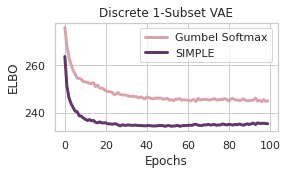

In [150]:
import seaborn as sns
# sns.set_theme(style="white")
plt.figure(figsize=(4, 2))
sns.set_theme(style="whitegrid")
colors = [sns.cubehelix_palette(as_cmap=False)[i] for i in range(6)]
# colors = sns.cubehelix_palette(reverse=True)

sns.set_theme(style="whitegrid", palette='pastel')#palette=sns.cubehelix_palette(light=0.7, n_colors=2))#palette=sns.color_palette("husl", 2))
ax = sns.lineplot(gumbel_softmax, c=colors[1], label='Gumbel Softmax', lw=3)
sns.lineplot(SIMPLE_res, c=colors[4], label='SIMPLE', lw=3)
ax.set(xlabel='Epochs', ylabel='ELBO', title='Discrete 1-Subset VAE')
plt.savefig('SIMPLE-GS.pdf',bbox_inches='tight')